In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, adjusted_mutual_info_score, silhouette_samples
)
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import skew, kurtosis
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
file_path = "penguins.csv"   # или полный путь

data = pd.read_csv(file_path)

print("Размер данных:", data.shape)
print(data.head())

Размер данных: (344, 5)
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE


In [3]:
print("Типы столбцов:\n", data.dtypes)
print('\nПропуски по столбцам:\n', data.isnull().sum())
print('\nУникальные виды:', data['sex'].unique())

Типы столбцов:
 culmen_length_mm     float64
culmen_depth_mm      float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

Пропуски по столбцам:
 culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

Уникальные виды: ['MALE' 'FEMALE' nan '.']


In [4]:
data = data.dropna()
data = data.drop(data[data['sex'] == "."].index)
print('\nПропуски по столбцам:\n', data.isnull().sum())
print('\nУникальные виды:', data['sex'].unique())


Пропуски по столбцам:
 culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Уникальные виды: ['MALE' 'FEMALE']


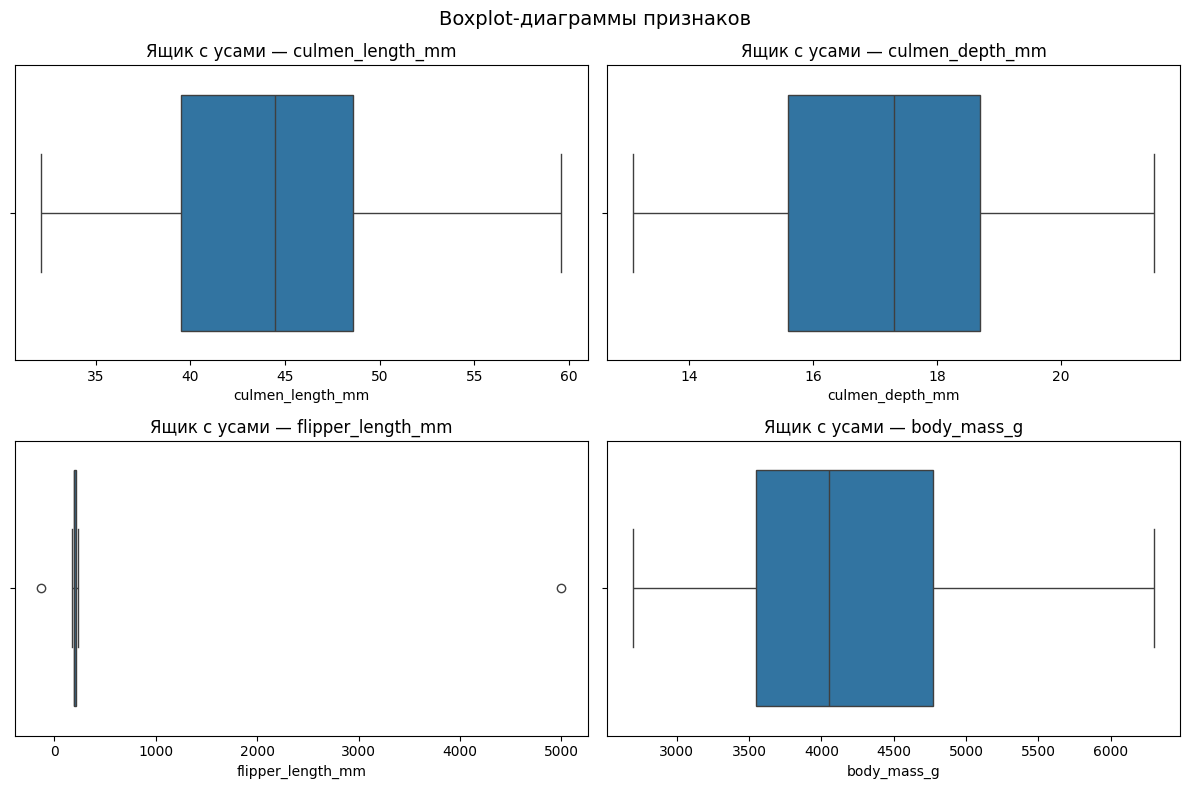

In [5]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=data[col], ax=axs[i])
    axs[i].set_title(f'Ящик с усами — {col}')
    axs[i].set_xlabel(col)

plt.suptitle('Boxplot-диаграммы признаков', fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
print('\nСтатистика по числовым признакам:\n', data.describe().T)


Статистика по числовым признакам:
                    count         mean         std     min     25%      50%  \
culmen_length_mm   334.0    43.986826    5.461540    32.1    39.5    44.45   
culmen_depth_mm    334.0    17.173952    1.973277    13.1    15.6    17.30   
flipper_length_mm  334.0   214.347305  263.648447  -132.0   190.0   197.00   
body_mass_g        334.0  4207.185629  804.009294  2700.0  3550.0  4050.00   

                        75%     max  
culmen_length_mm     48.575    59.6  
culmen_depth_mm      18.700    21.5  
flipper_length_mm   213.000  5000.0  
body_mass_g        4768.750  6300.0  


In [7]:
for col in numeric_cols:
    std = np.std(data[col], ddof=1)
    var = np.var(data[col], ddof=1)
    sk = skew(data[col])
    ku = kurtosis(data[col])

    print(
        f"{col}: "
        f"std={std:.3f}, "
        f"var={var:.3f}, "
        f"skew={sk:.3f}, "
        f"kurtosis={ku:.3f}"
    )

culmen_length_mm: std=5.462, var=29.828, skew=0.048, kurtosis=-0.883
culmen_depth_mm: std=1.973, var=3.894, skew=-0.151, kurtosis=-0.901
flipper_length_mm: std=263.648, var=69510.504, skew=17.980, kurtosis=323.990
body_mass_g: std=804.009, var=646430.944, skew=0.470, kurtosis=-0.734


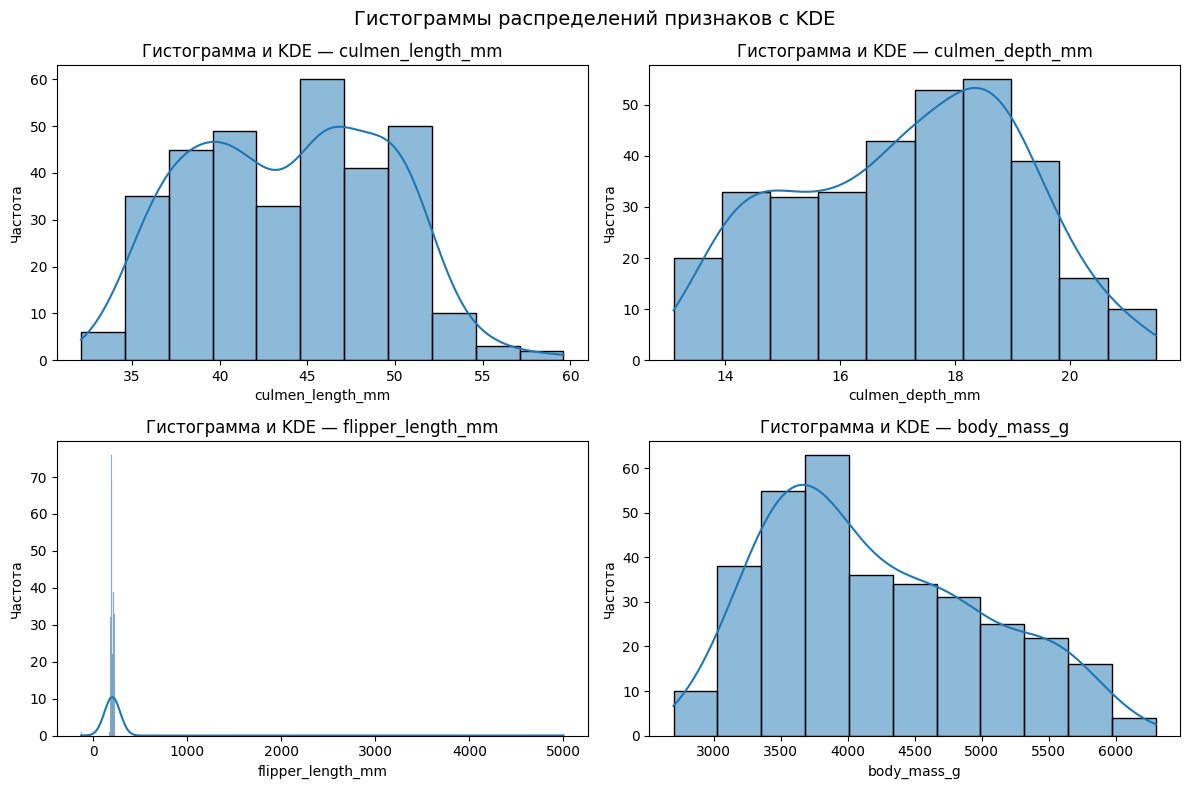

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], kde=True, ax=axs[i])
    axs[i].set_title(f'Гистограмма и KDE — {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Частота')

plt.suptitle('Гистограммы распределений признаков с KDE', fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
def remove_outliers_iqr(data, columns):
    data_clean = data.copy()
    
    for col in columns:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data_clean = data_clean[(data_clean[col] >= lower_bound) & 
                                (data_clean[col] <= upper_bound)]
    
    return data_clean

data_clean_iqr = remove_outliers_iqr(data, numeric_cols)

print(f"Исходный размер: {data.shape}")
data = data_clean_iqr
print(f"Размер после удаления выбросов: {data_clean_iqr.shape}")

Исходный размер: (334, 5)
Размер после удаления выбросов: (332, 5)


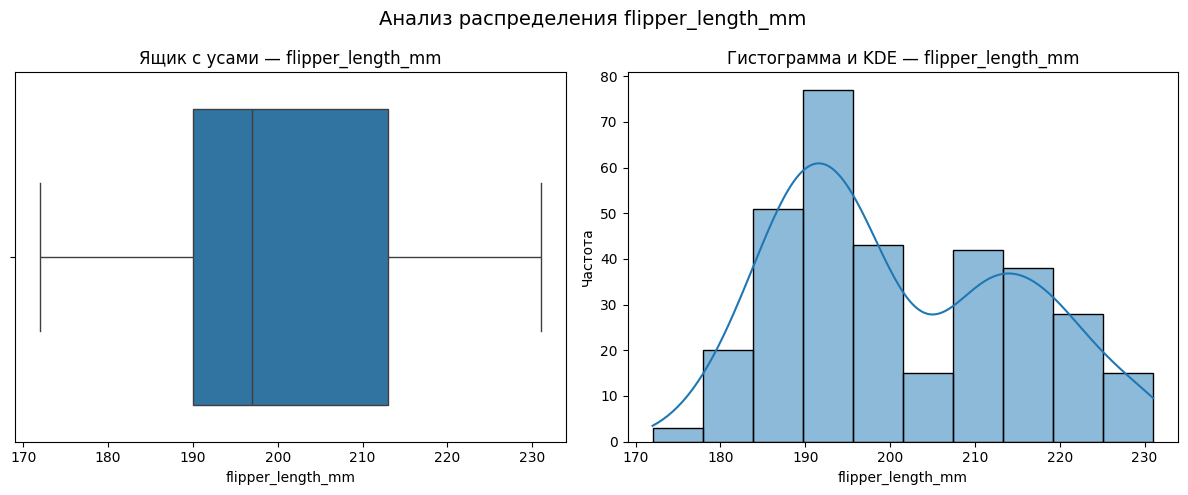

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot для flipper_length_mm
sns.boxplot(x=data['flipper_length_mm'], ax=axs[0])
axs[0].set_title('Ящик с усами — flipper_length_mm')
axs[0].set_xlabel('flipper_length_mm')

# Гистограмма с KDE для flipper_length_mm
sns.histplot(data['flipper_length_mm'], kde=True, ax=axs[1])
axs[1].set_title('Гистограмма и KDE — flipper_length_mm')
axs[1].set_xlabel('flipper_length_mm')
axs[1].set_ylabel('Частота')

plt.suptitle('Анализ распределения flipper_length_mm', fontsize=14)
plt.tight_layout()
plt.show()

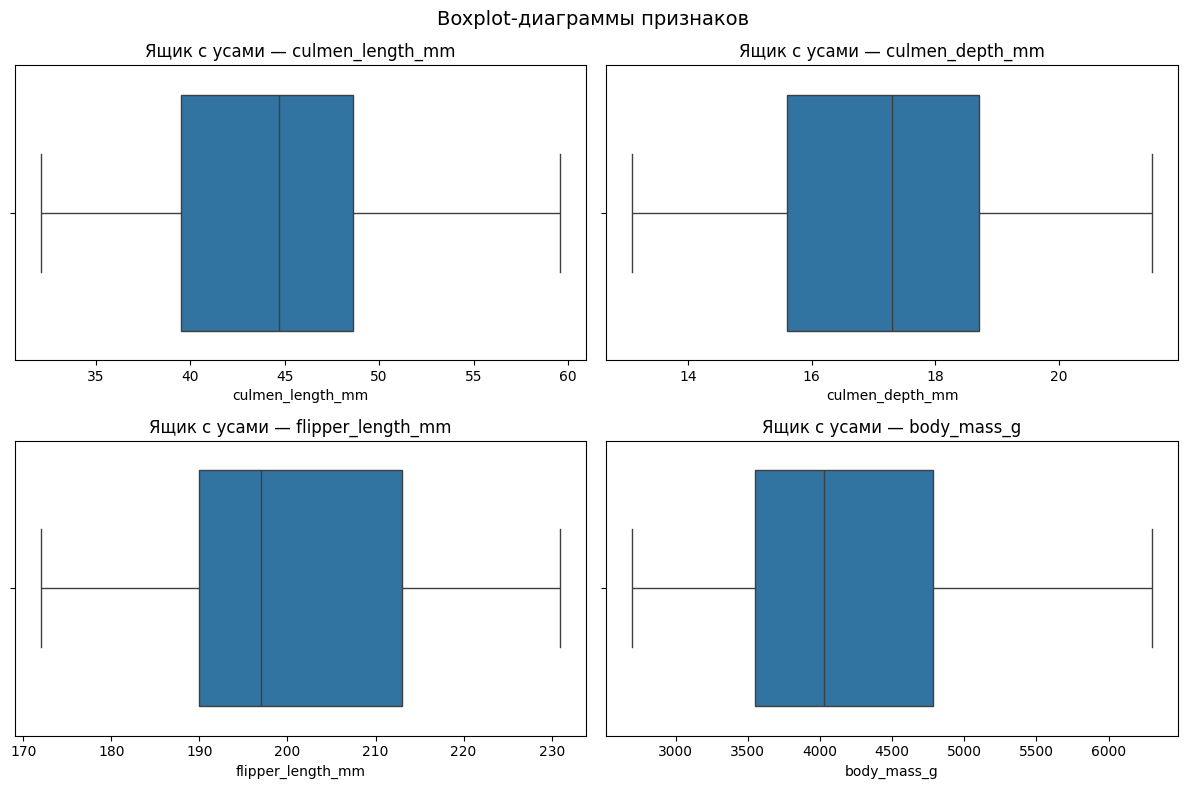

In [11]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=data[col], ax=axs[i])
    axs[i].set_title(f'Ящик с усами — {col}')
    axs[i].set_xlabel(col)

plt.suptitle('Boxplot-диаграммы признаков', fontsize=14)
plt.tight_layout()
plt.show()

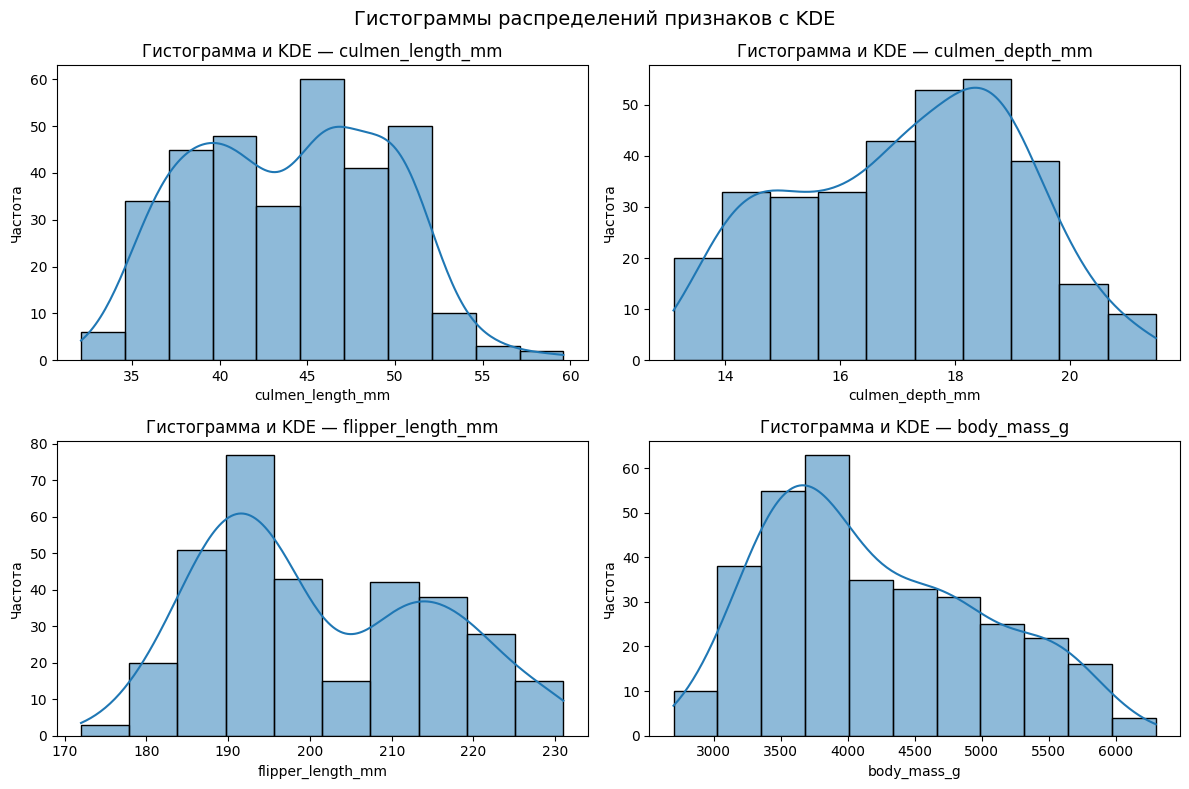

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], kde=True, ax=axs[i])
    axs[i].set_title(f'Гистограмма и KDE — {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Частота')

plt.suptitle('Гистограммы распределений признаков с KDE', fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
for col in numeric_cols:
    std = np.std(data[col], ddof=1)      # среднеквадратичное отклонение (выборочное)
    var = np.var(data[col], ddof=1)      # дисперсия (выборочная)
    sk = skew(data[col])
    ku = kurtosis(data[col])

    print(
        f"{col}: "
        f"std={std:.3f}, "
        f"var={var:.3f}, "
        f"skew={sk:.3f}, "
        f"kurtosis={ku:.3f}"
    )

culmen_length_mm: std=5.452, var=29.729, skew=0.046, kurtosis=-0.884
culmen_depth_mm: std=1.960, var=3.843, skew=-0.158, kurtosis=-0.905
flipper_length_mm: std=14.036, var=197.008, skew=0.356, kurtosis=-0.971
body_mass_g: std=806.361, var=650218.510, skew=0.472, kurtosis=-0.745


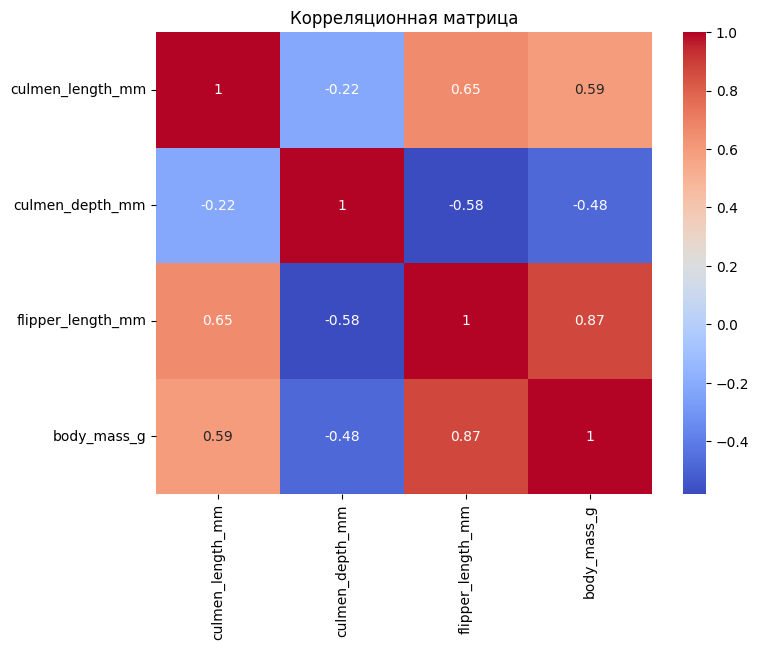

In [14]:
corr = data[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

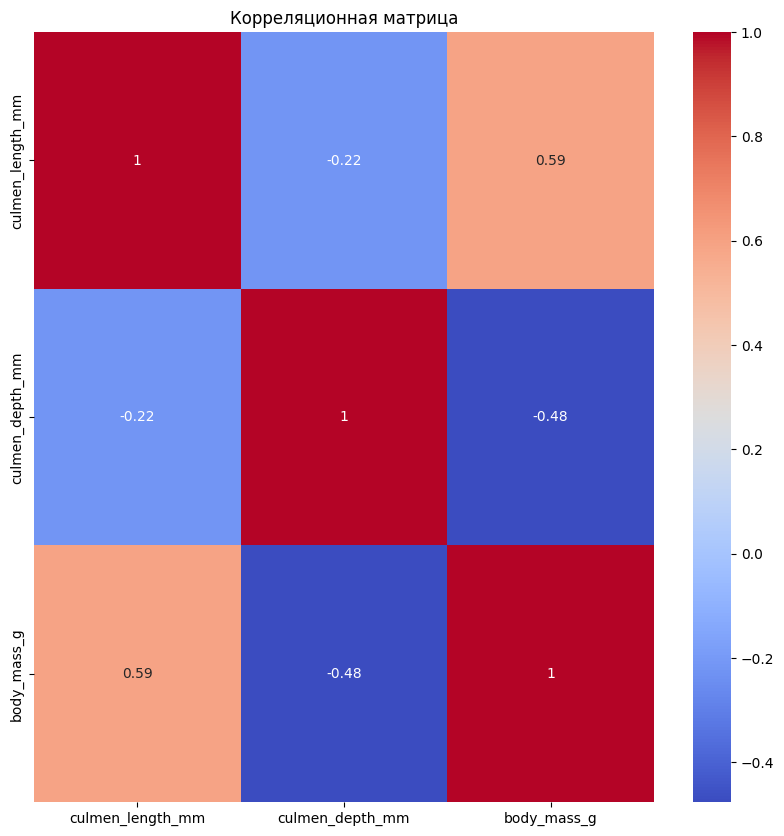

In [15]:
data = data.drop(columns=['flipper_length_mm'], axis=1)
numeric_cols.remove('flipper_length_mm')
corr = data[numeric_cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [16]:
X = data[numeric_cols]
y = data['sex']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols)

print('\nСреднее после стандартизации:', X_scaled_df.mean().to_frame())
print('Стандартное отклонение:', X_scaled_df.std().to_frame())


Среднее после стандартизации:                              0
culmen_length_mm -4.708416e-16
culmen_depth_mm   1.284113e-16
body_mass_g       4.280378e-17
Стандартное отклонение:                          0
culmen_length_mm  1.001509
culmen_depth_mm   1.001509
body_mass_g       1.001509


In [17]:
display(X_scaled_df)

,culmen_length_mm,culmen_depth_mm,body_mass_g
0,-0.903906,0.790360,-0.566948
1,-0.830434,0.126187,-0.504847
2,-0.683490,0.432728,-1.187953
3,-1.344738,1.096901,-0.939551
4,-0.867170,1.761074,-0.691149
...,...,...,...
327,0.583904,-1.764152,0.892415
328,0.510432,-1.457611,0.799264
329,1.171681,-0.742347,1.917074
330,0.216543,-1.202160,1.233968


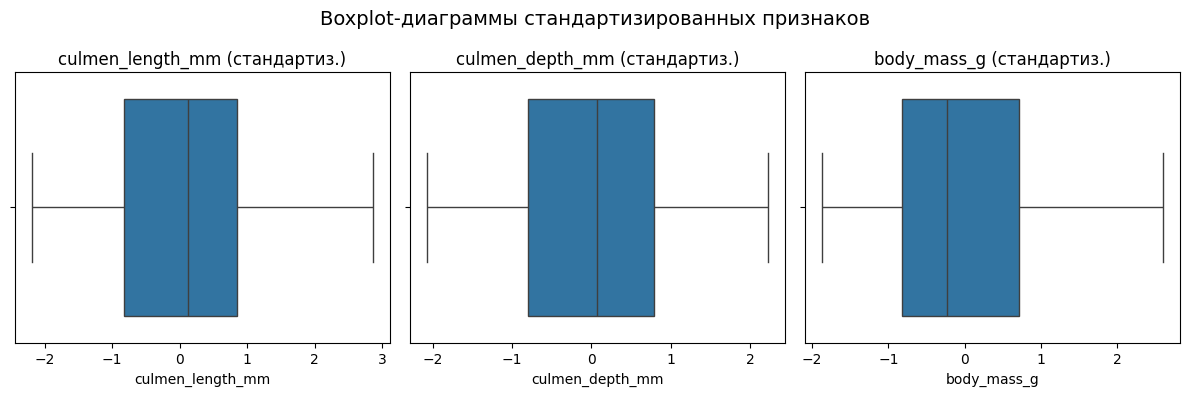

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=X_scaled_df[col], ax=axs[i])
    axs[i].set_title(f'{col} (стандартиз.)')
    axs[i].set_xlabel(col)

plt.suptitle('Boxplot-диаграммы стандартизированных признаков', fontsize=14)
plt.tight_layout()
plt.show()


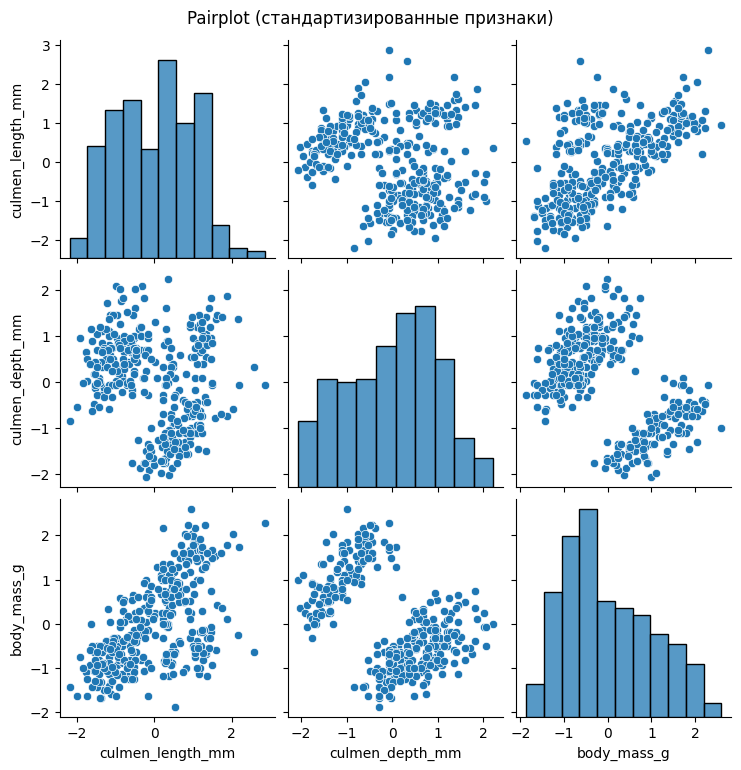

In [19]:
sns.pairplot(pd.concat([X_scaled_df, data['sex']], axis=1), diag_kind='hist')
plt.suptitle('Pairplot (стандартизированные признаки)', y=1.02)
plt.show()

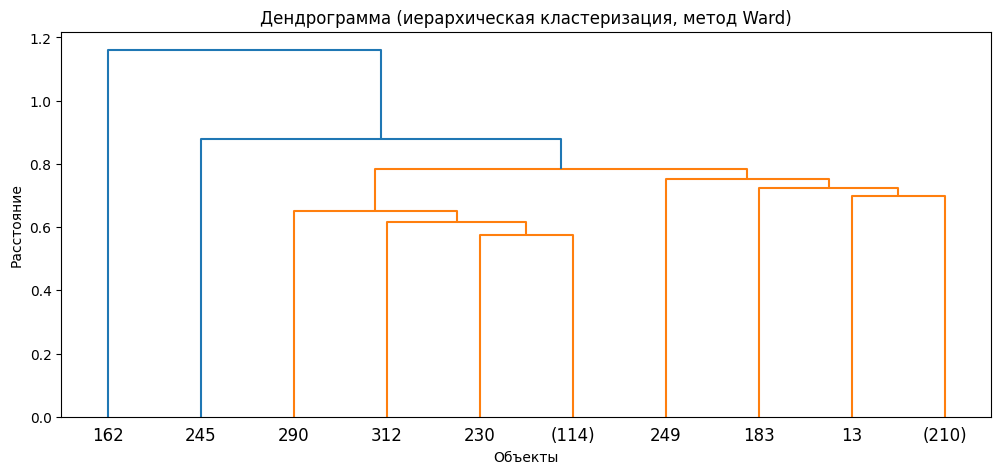

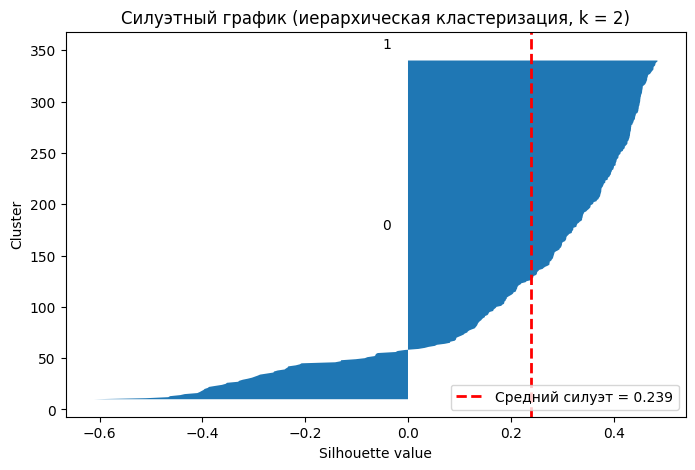

In [35]:
K_range = range(2, 8)

Z = linkage(X_scaled, method='single')

plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Дендрограмма (иерархическая кластеризация, метод Ward)')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()

hier_model = AgglomerativeClustering(n_clusters=2, linkage='single')
hier_labels = hier_model.fit_predict(X_scaled)

sil_values = silhouette_samples(X_scaled, hier_labels)
avg_sil = silhouette_score(X_scaled, hier_labels)


fig, ax = plt.subplots(figsize=(8, 5))
y_lower = 10

for cluster in range(2):
    vals = sil_values[hier_labels == cluster]
    vals.sort()
    size = len(vals)
    y_upper = y_lower + size

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        vals
    )
    ax.text(-0.05, y_lower + size / 2, str(cluster))
    y_lower = y_upper + 10

ax.axvline(
    avg_sil,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Средний силуэт = {avg_sil:.3f}'
)

ax.set_title('Силуэтный график (иерархическая кластеризация, k = 2)')
ax.set_xlabel('Silhouette value')
ax.set_ylabel('Cluster')
ax.legend(loc='lower right')

plt.show()

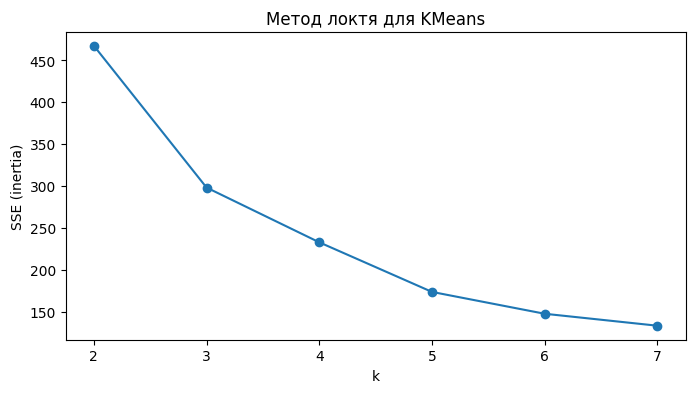

SSE:  467.4775567763901
SSE:  298.46839668952197
SSE:  233.252586323287
SSE:  174.15658834591952
SSE:  148.13051627873622
SSE:  133.8893388144886


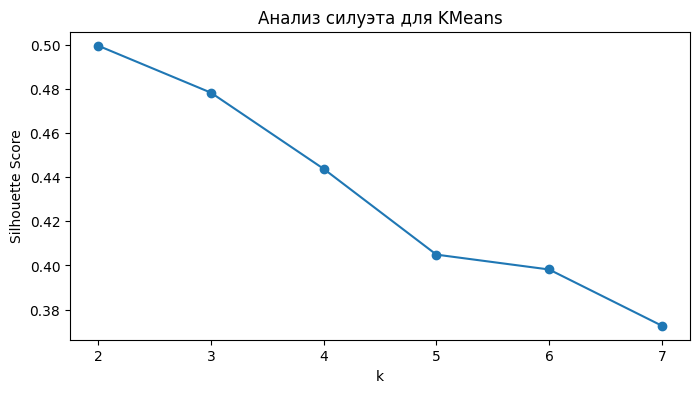

Silhouette scores (KMeans): {2: 0.5, 3: 0.478, 4: 0.444, 5: 0.405, 6: 0.398, 7: 0.373}
Оптимальное k для KMeans: 2


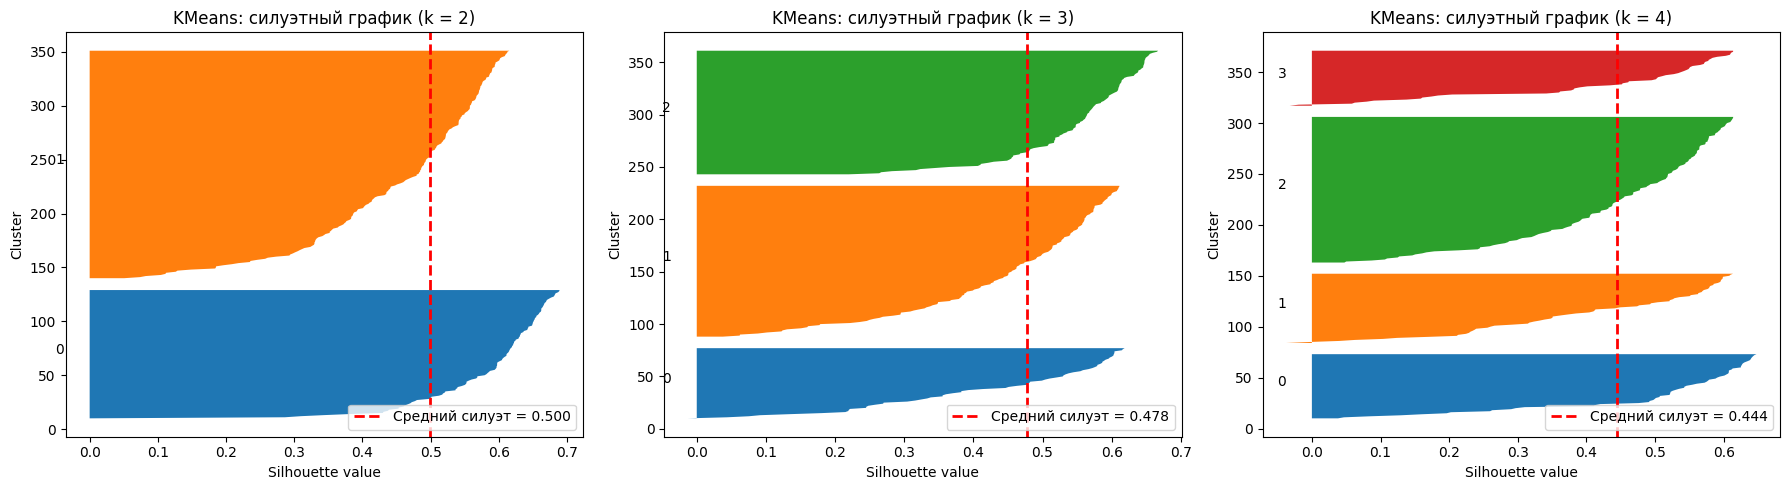

In [ ]:
kmeans_sse = []
kmeans_sil = {}

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    kmeans_sse.append(kmeans.inertia_)
    kmeans_sil[k] = silhouette_score(X_scaled, labels)

best_k_kmeans = max(kmeans_sil, key=kmeans_sil.get)

plt.figure(figsize=(8, 4))
plt.plot(K_range, kmeans_sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE (inertia)')
plt.title('Метод локтя для KMeans')
plt.show()

for ksse in kmeans_sse:
    print("SSE: ", ksse)

plt.figure(figsize=(8, 4))
plt.plot(list(kmeans_sil.keys()), list(kmeans_sil.values()), marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Анализ силуэта для KMeans')
plt.show()

print('Silhouette scores (KMeans):', {k: round(v, 3) for k, v in kmeans_sil.items()})
print('Оптимальное k для KMeans:', best_k_kmeans)

k_values = [2, 3, 4]

plt.figure(figsize=(18, 5))

for idx, k in enumerate(k_values, 1):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels_kmeans = kmeans.fit_predict(X_scaled)

    sil_values = silhouette_samples(X_scaled, labels_kmeans)
    avg_sil = silhouette_score(X_scaled, labels_kmeans)

    ax = plt.subplot(1, 3, idx)
    y_lower = 10

    for cluster in range(k):
        vals = sil_values[labels_kmeans == cluster]
        vals.sort()
        size = len(vals)
        y_upper = y_lower + size

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            vals
        )
        ax.text(-0.05, y_lower + size / 2, str(cluster))
        y_lower = y_upper + 10

    ax.axvline(
        avg_sil,
        color='red',
        linestyle='--',
        linewidth=2,
        label=f'Средний силуэт = {avg_sil:.3f}'
    )

    ax.set_title(f'KMeans: силуэтный график (k = {k})')
    ax.set_xlabel('Silhouette value')
    ax.set_ylabel('Cluster')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [22]:
k_opt_hier = 2

hierarchical = AgglomerativeClustering(
    n_clusters=k_opt_hier,
    linkage='ward'
)
hier_labels = hierarchical.fit_predict(X_scaled)

print('Оптимальное k для иерархической кластеризации:', k_opt_hier)

Оптимальное k для иерархической кластеризации: 2


In [23]:
k_opt_kmeans = 2
kmeans = KMeans(n_clusters=k_opt_kmeans, random_state=0, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)
print('Оптимальное k для kmeans:', k_opt_kmeans)

Оптимальное k для kmeans: 2


In [24]:
def evaluate_clustering(X, labels, method_name, true_labels=None):
    metrics = {}

    metrics['silhouette'] = silhouette_score(X, labels)
    metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    metrics['davies_bouldin'] = davies_bouldin_score(X, labels)

    if true_labels is not None:
        from sklearn.preprocessing import LabelEncoder
        import itertools

        le = LabelEncoder()
        y_true = le.fit_transform(true_labels)

        metrics['adjusted_rand'] = adjusted_rand_score(y_true, labels)
        metrics['adjusted_mutual_info'] = adjusted_mutual_info_score(y_true, labels)

        pairs = itertools.combinations(range(len(y_true)), 2)
        intersect = 0
        union = 0

        for i, j in pairs:
            same_true = (y_true[i] == y_true[j])
            same_pred = (labels[i] == labels[j])

            if same_true and same_pred:
                intersect += 1
            if same_true or same_pred:
                union += 1

        metrics['jaccard_pairwise'] = intersect / union if union > 0 else None

    print(f"\nМетрики для {method_name}:")
    for k, v in metrics.items():
        print(f"{k}: {round(v, 4) if v is not None else v}")

    return metrics

hierarchical_metrics = evaluate_clustering(
    X_scaled,
    hier_labels,
    f'Hierarchical (k={k_opt_hier})',
    true_labels=data['sex']
)
kmeans_metrics = evaluate_clustering(
    X_scaled,
    k_labels,
    f'KMeans (k={k_opt_kmeans})',
    true_labels=data['sex']
)


Метрики для Hierarchical (k=2):
silhouette: 0.4983
calinski_harabasz: 369.4851
davies_bouldin: 0.7867
adjusted_rand: -0.0027
adjusted_mutual_info: -0.0022
jaccard_pairwise: 0.3489

Метрики для KMeans (k=2):
silhouette: 0.4996
calinski_harabasz: 373.0926
davies_bouldin: 0.7908
adjusted_rand: -0.0028
adjusted_mutual_info: -0.0022
jaccard_pairwise: 0.3474



Доля объясненной дисперсии (2 компоненты): [0.62580196 0.88768389]


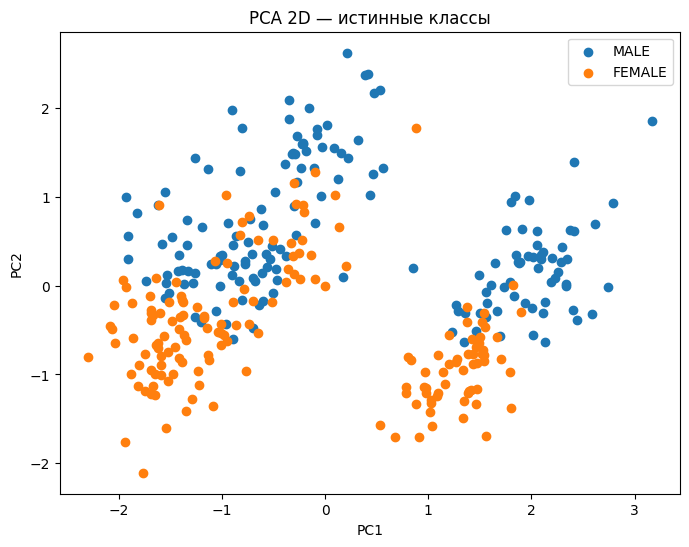

In [25]:
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)
print('\nДоля объясненной дисперсии (2 компоненты):', pca.explained_variance_ratio_.cumsum())


plt.figure(figsize=(8,6))
for species in data['sex'].unique():
    mask = data['sex'] == species
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=species)
plt.legend()
plt.title('PCA 2D — истинные классы')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [26]:
hier_df = pd.DataFrame(X_scaled, columns=numeric_cols)
hier_df['cluster'] = hier_labels

hier_centers_scaled = hier_df.groupby('cluster').mean()

hier_centers_original = scaler.inverse_transform(hier_centers_scaled)

hier_centers_df = pd.DataFrame(
    hier_centers_original,
    columns=numeric_cols
)
hier_centers_df.index.name = 'cluster'

print('\nЦентры кластеров иерархической кластеризации (в исходных единицах):')
print(hier_centers_df)

centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=numeric_cols)
centers_df.index.name = 'cluster'
print('\nЦентры кластеров (в исходных единицах):\n', centers_df)


Центры кластеров иерархической кластеризации (в исходных единицах):
         culmen_length_mm  culmen_depth_mm  body_mass_g
cluster                                                
0               42.050467        18.352804  3718.691589
1               47.594915        14.977119  5091.101695

Центры кластеров (в исходных единицах):
          culmen_length_mm  culmen_depth_mm  body_mass_g
cluster                                                
0               47.655000        15.020000  5080.833333
1               41.964151        18.360377  3711.556604



Иерархическая кластеризация
Количество объектов в кластерах:
cluster
0    214
1    118
Name: count, dtype: int64
WSS: 469.8885137262753
TSS: 995.9999999999999
BSS: 526.1114862737246

Центры кластеров (иерархическая, PCA):
        PC1       PC2
0 -0.907870  0.219578
1  1.646475 -0.398218

KMeans
Количество объектов в кластерах:
cluster
0    120
1    212
Name: count, dtype: int64
WSS (inertia): 467.47755677639003
TSS: 995.9999999999999
BSS: 528.5224432236098

Центры кластеров KMeans (PCA):
        PC1       PC2
0  1.633476 -0.375137
1 -0.924609  0.212342


c:\Users\super\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


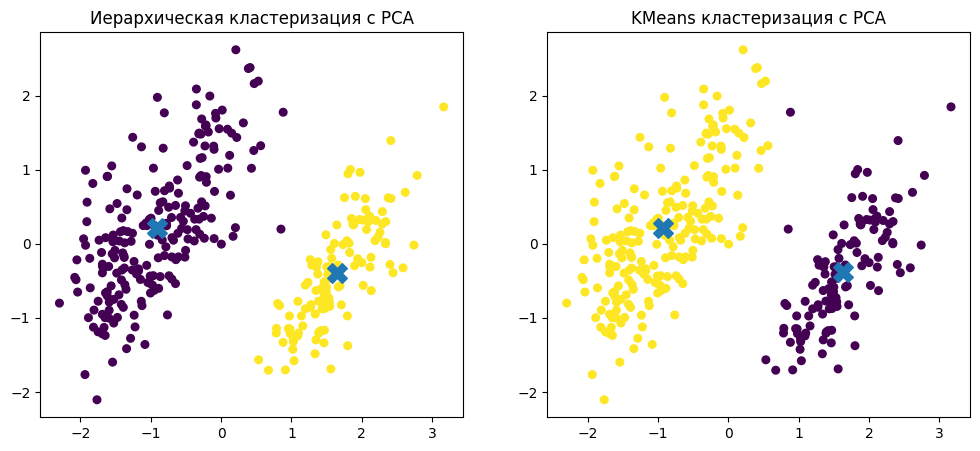

In [27]:
def clustering_statistics(X, labels, centers):
    stats = {}

    df = pd.DataFrame(X)
    df['cluster'] = labels

    cluster_sizes = df['cluster'].value_counts().sort_index()
    stats['cluster_sizes'] = cluster_sizes

    wss = 0
    for k in cluster_sizes.index:
        cluster_points = X[labels == k]
        center = centers[k]
        wss += np.sum((cluster_points - center) ** 2)

    global_mean = np.mean(X, axis=0)
    tss = np.sum((X - global_mean) ** 2)

    bss = tss - wss

    stats['WSS'] = wss
    stats['TSS'] = tss
    stats['BSS'] = bss

    return stats

hier_stats = clustering_statistics(
    X_scaled,
    hier_labels,
    hier_centers_scaled.values
)

print('\nИерархическая кластеризация')
print('Количество объектов в кластерах:')
print(hier_stats['cluster_sizes'])
print('WSS:', hier_stats['WSS'])
print('TSS:', hier_stats['TSS'])
print('BSS:', hier_stats['BSS'])

hier_centers_pca = pca.transform(hier_centers_scaled)
hier_centers_pca_df = pd.DataFrame(hier_centers_pca, columns=("PC1", "PC2"))
print('\nЦентры кластеров (иерархическая, PCA):')
print(hier_centers_pca_df)


kmeans_stats = clustering_statistics(
    X_scaled,
    k_labels,
    centers_scaled
)

print('\nKMeans')
print('Количество объектов в кластерах:')
print(kmeans_stats['cluster_sizes'])
print('WSS (inertia):', kmeans_stats['WSS'])
print('TSS:', kmeans_stats['TSS'])
print('BSS:', kmeans_stats['BSS'])
centers_pca = pca.transform(centers_scaled)
centers_pca_df = pd.DataFrame(centers_pca, columns=("PC1", "PC2"))
print('\nЦентры кластеров KMeans (PCA):')
print(centers_pca_df)



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Иерархическая кластеризация с PCA')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hier_labels, cmap='viridis', s=30)


plt.scatter(
    hier_centers_pca[:, 0],
    hier_centers_pca[:, 1],
    marker='X',
    s=200
)

plt.subplot(1, 2, 2)
plt.title('KMeans кластеризация с PCA')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=k_labels, cmap='viridis', s=30)


plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    marker='X',
    s=200
)

plt.show()

In [28]:
from sklearn.preprocessing import LabelEncoder
import itertools

def evaluate_clustering(X, labels, method_name, true_labels=None):
    metrics = {}

    metrics['silhouette'] = silhouette_score(X, labels)
    metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    metrics['davies_bouldin'] = davies_bouldin_score(X, labels)

    if true_labels is not None:
        le = LabelEncoder()
        y_true = le.fit_transform(true_labels)

        metrics['adjusted_rand'] = adjusted_rand_score(y_true, labels)
        metrics['adjusted_mutual_info'] = adjusted_mutual_info_score(y_true, labels)

        pairs = list(itertools.combinations(range(len(y_true)), 2))
        tp = tn = fp = fn = 0
        intersect = union = 0

        for i, j in pairs:
            same_true = (y_true[i] == y_true[j])
            same_pred = (labels[i] == labels[j])

            if same_true and same_pred:
                tp += 1
            elif same_true and not same_pred:
                fn += 1
            elif not same_true and same_pred:
                fp += 1
            else:
                tn += 1

            if same_true and same_pred:
                intersect += 1
            if same_true or same_pred:
                union += 1

        total_pairs = tp + tn + fp + fn
        metrics['rand'] = (tp + tn) / total_pairs if total_pairs > 0 else None

        metrics['jaccard'] = intersect / union if union > 0 else None

    print(f"\nМетрики для {method_name}:")
    for k, v in metrics.items():
        print(f"{k}: {round(v, 4) if isinstance(v, float) else v}")

    return metrics

hierarchical_metrics = evaluate_clustering(
    X_scaled,
    hier_labels,
    f'Иерархическая кластеризация (k={k_opt_hier})',
    true_labels=data['sex']
)

kmeans_metrics = evaluate_clustering(
    X_scaled,
    k_labels,
    f'KMeans (k={k_opt_kmeans})',
    true_labels=data['sex']
)


Метрики для Иерархическая кластеризация (k=2):
silhouette: 0.4983
calinski_harabasz: 369.4851
davies_bouldin: 0.7867
adjusted_rand: -0.0027
adjusted_mutual_info: -0.0022
rand: 0.4985
jaccard: 0.3489

Метрики для KMeans (k=2):
silhouette: 0.4996
calinski_harabasz: 373.0926
davies_bouldin: 0.7908
adjusted_rand: -0.0028
adjusted_mutual_info: -0.0022
rand: 0.4985
jaccard: 0.3474


In [29]:
results = {
    'method': ['Иерарх. кластеризация', 'KMeans'],
    'silhouette': [hierarchical_metrics['silhouette'], kmeans_metrics['silhouette']],
    'calinski_harabasz': [hierarchical_metrics['calinski_harabasz'], kmeans_metrics['calinski_harabasz']],
    'davies_bouldin': [hierarchical_metrics['davies_bouldin'], kmeans_metrics['davies_bouldin']],
    'adjusted_rand': [hierarchical_metrics['adjusted_rand'], kmeans_metrics['adjusted_rand']],
    'rand': [hierarchical_metrics['rand'], kmeans_metrics['rand']],
    'jaccard': [hierarchical_metrics['jaccard'], kmeans_metrics['jaccard']],
    'adjusted_mutual_info': [hierarchical_metrics.get('adjusted_mutual_info'), kmeans_metrics.get('adjusted_mutual_info')]
}

res_df = pd.DataFrame(results)
print('\nСводная таблица результатов:\n', res_df)


Сводная таблица результатов:
                   method  silhouette  calinski_harabasz  davies_bouldin  \
0  Иерарх. кластеризация    0.498288         369.485070        0.786734   
1                 KMeans    0.499562         373.092577        0.790755   

   adjusted_rand      rand   jaccard  adjusted_mutual_info  
0      -0.002743  0.498508  0.348889             -0.002209  
1      -0.002763  0.498508  0.347440             -0.002204  


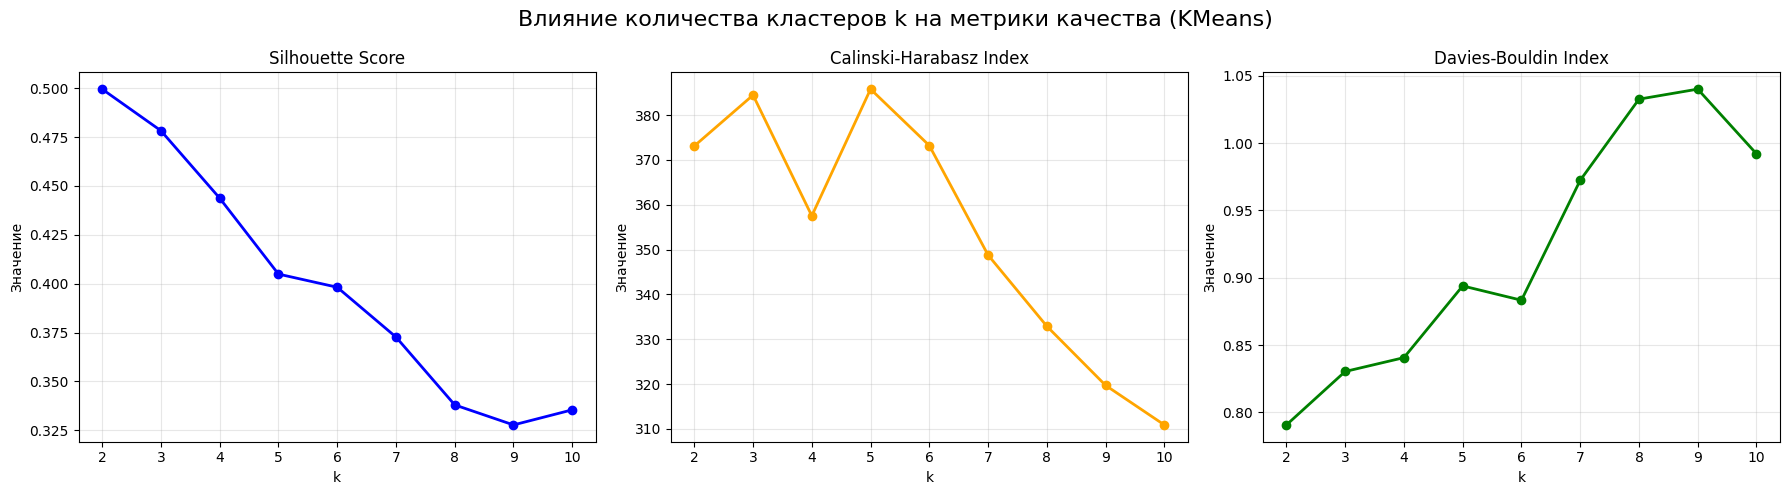

k	Silhouette	Calinski-Harabasz	Davies-Bouldin
2	0.500		373.093			0.791
3	0.478		384.443			0.830
4	0.444		357.525			0.841
5	0.405		385.778			0.894
6	0.398		373.192			0.883
7	0.373		348.778			0.972
8	0.338		332.909			1.033
9	0.328		319.723			1.040
10	0.335		310.905			0.992


In [30]:
import matplotlib.pyplot as plt
import numpy as np

ks = list(range(2,11))
sil_by_k = []
ch_by_k = []
db_by_k = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_by_k.append(silhouette_score(X_scaled, labels))
    ch_by_k.append(calinski_harabasz_score(X_scaled, labels))
    db_by_k.append(davies_bouldin_score(X_scaled, labels))

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

axs[0].plot(ks, sil_by_k, marker='o', linewidth=2, color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Значение')
axs[0].grid(True, alpha=0.3)
axs[0].set_xticks(ks)

axs[1].plot(ks, ch_by_k, marker='o', linewidth=2, color='orange')
axs[1].set_title('Calinski-Harabasz Index')
axs[1].set_xlabel('k')
axs[1].set_ylabel('Значение')
axs[1].grid(True, alpha=0.3)
axs[1].set_xticks(ks)

axs[2].plot(ks, db_by_k, marker='o', linewidth=2, color='green')
axs[2].set_title('Davies-Bouldin Index')
axs[2].set_xlabel('k')
axs[2].set_ylabel('Значение')
axs[2].grid(True, alpha=0.3)
axs[2].set_xticks(ks)

fig.suptitle('Влияние количества кластеров k на метрики качества (KMeans)', fontsize=16)

plt.tight_layout()
plt.show()

print("k\tSilhouette\tCalinski-Harabasz\tDavies-Bouldin")
for i, k in enumerate(ks):
    print(f"{k}\t{sil_by_k[i]:.3f}\t\t{ch_by_k[i]:.3f}\t\t\t{db_by_k[i]:.3f}")